Connected to integrating (Python 3.11.5)

In [6]:
from PointList import *

class TriangularMesh:
    def __init__(self, boundary : PointList, desired_triangle_count):
        self.boundary = boundary
        self.m = desired_triangle_count
        self.mesh = []
        self.n = len(boundary)
        
        

    def compute_central_point(self):
        return self.boundary.average_point()
        
        

    def create_initial_subdivisions(self):
        #  Create initial subdivisions using the central point
        C = self.compute_central_point()
        s = int(self.m/2*self.n - 1/2)
        P = []
        for j in range(1,s+1):
            P_j = self.boundary + (j / (s+1))*(C - self.boundary)
            P.append(P_j)
        return P
        



    def split_quadrilaterals(self):
        # TODO: Split any quadrilaterals into triangles
        pass

    def further_subdivide(self):
        # TODO: Further subdivide triangles if the count doesn't match the desired amount
        pass

    def generate_mesh(self):
        self.compute_central_point()
        self.create_initial_subdivisions()
        self.split_quadrilaterals()
        self.further_subdivide()
        return self.mesh


C = PointList()
# # Usage example:
# if __name__ == "__main__":
#     boundary = [(x1, y1), (x2, y2), ...]  # Define the boundary vertices here
#     desired_triangle_count = m  # Set the desired triangle count here
#     mesh_generator = TriangularMesh(boundary, desired_triangle_count)
#     mesh = mesh_generator.generate_mesh()
#     print(mesh)

In [8]:
c = PointList()

In [3]:
import numpy as np

class PointList:
    def __init__(self):
        self.points = []

    def add_point(self, point):
        self.points.append(np.array(point))

    def sum_points(self):
        total = np.sum(self.points, axis=0)
        return total

    def average_point(self):
        avg = np.mean(self.points, axis=0)
        return avg

    def display_points(self):
        for point in self.points:
            print(point)


In [4]:
c = PointList()

In [5]:
c

In [9]:
c.add_point((4,7))

In [7]:
c

In [10]:
c.add_point((7,9))

In [11]:
c.add_point((7,4))

In [12]:
c.add_point((8,6))

In [13]:
c.add_point((2,9))

In [14]:
c.add_point((4,0))

In [13]:
K = TriangularMesh(c.points,10)

In [14]:
K.create_initial_subdivisions

<bound method TriangularMesh.create_initial_subdivisions of <__main__.TriangularMesh object at 0x000001F7CE0F3F50>>

In [15]:
P = K.create_initial_subdivisions()

AttributeError: 'list' object has no attribute 'average_point'

In [16]:
K

In [15]:
from PointList import *

class TriangularMesh:
    def __init__(self, boundary : PointList, desired_triangle_count):
        self.boundary = boundary
        self.m = desired_triangle_count
        self.mesh = []
        self.n = len(boundary)
        
        

    def compute_central_point(self):
        return self.boundary.average_point()
        
        

    def create_initial_subdivisions(self):
        #  Create initial subdivisions using the central point
        C = self.boundary.compute_central_point()
        s = int(self.m/2*self.n - 1/2)
        P = []
        for j in range(1,s+1):
            P_j = self.boundary + (j / (s+1))*(C - self.boundary)
            P.append(P_j)
        return P
        



    def split_quadrilaterals(self):
        # TODO: Split any quadrilaterals into triangles
        pass

    def further_subdivide(self):
        # TODO: Further subdivide triangles if the count doesn't match the desired amount
        pass

    def generate_mesh(self):
        self.compute_central_point()
        self.create_initial_subdivisions()
        self.split_quadrilaterals()
        self.further_subdivide()
        return self.mesh




In [18]:
P = K.create_initial_subdivisions()

AttributeError: 'list' object has no attribute 'average_point'

In [31]:
from PointList import *

class TriangularMesh:
    def __init__(self, boundary : PointList, desired_triangle_count):
        self.boundary = boundary
        self.m = desired_triangle_count
        self.mesh = []
        self.n = len(boundary.points)
        
        

    def compute_central_point(self):
        return self.boundary.average_point()
        
        

    def create_initial_subdivisions(self):
        #  Create initial subdivisions using the central point
        C = self.compute_central_point()
        s = int(self.m/2*self.n - 1/2)
        P = []
        for j in range(1,s+1):
            P_j = self.boundary.points + (j / (s+1))*(C - self.boundary.points)
            P.append(P_j)
        return P
        



    def split_quadrilaterals(self):
        # TODO: Split any quadrilaterals into triangles
        pass

    def further_subdivide(self):
        # TODO: Further subdivide triangles if the count doesn't match the desired amount
        pass

    def generate_mesh(self):
        self.compute_central_point()
        self.create_initial_subdivisions()
        self.split_quadrilaterals()
        self.further_subdivide()
        return self.mesh


K = TriangularMesh(c,10)


In [34]:
P = K.create_initial_subdivisions()

In [40]:
R = np.array(P).reshape(-1,2)

In [39]:
import matplotlib.pyplot as plt

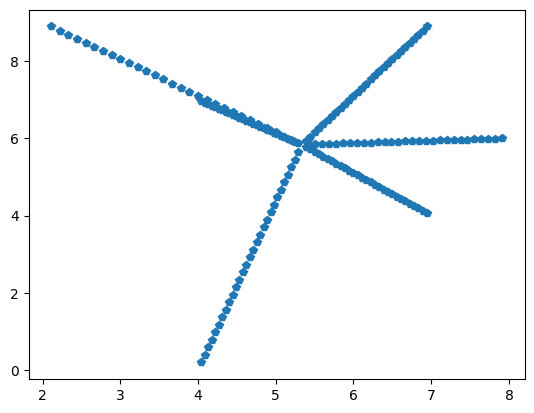

In [45]:
x = R[:,0]
y = R[:,1]
plt.plot(x,y,'p')

In [274]:
c = PointList()
c.add_point((2,3))
c.add_point((1,7))
c.add_point((5,9))
c.add_point((10,8))
c.add_point((11,4))



100%|██████████| 5/5 [00:00<?, ?it/s]


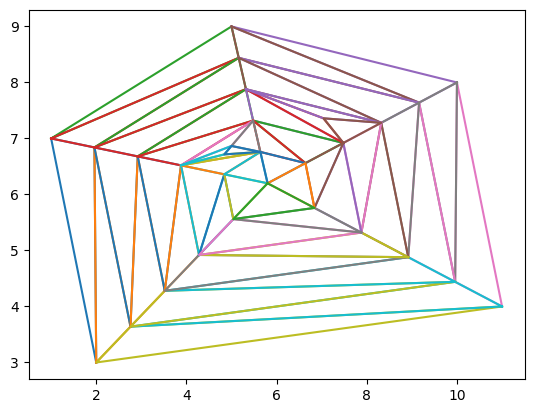

In [344]:
from PointList import *

class TriangularMesh:
    def __init__(self, boundary : PointList, desired_triangle_count):
        self.boundary = boundary 
        self.m = desired_triangle_count
        self.mesh = []
        self.n = len(boundary.points)
        
        

    def compute_central_point(self):
        return self.boundary.average_point()
        
        

    def create_initial_subdivisions(self):
        #  Create initial subdivisions using the central point
        C = self.compute_central_point()
        s = int(self.m/(2*self.n) - 1/2)
        triangle = self.boundary.points + [self.boundary.points[0]]
        P = [triangle]
        for j in range(1,s+1):
            P_j = triangle + (j / (s+1))*(C - triangle)
            P.append(P_j)
        
        return np.array(P)
        

    def create_quadrilaterals(self):
        #split the outside quadrilaterals
        P = (self.create_initial_subdivisions())
        # P.append(P[0])
        # P = np.array(P)
        s = int(self.m/(2*self.n) - 1/2)
        for j in tqdm(range(s)) : 
            for i in range(self.n) :
                self.mesh.append([P[j,i],P[j+1,i+1],P[j,i+1]])
                self.mesh.append([P[j,i],P[j+1,i+1],P[j+1,i]])
        
        


    def split_quadrilateral(self):
        C = self.compute_central_point()
        P = self.create_initial_subdivisions()
        for i in tqdm(range(self.n)) :
            self.mesh.append([C,P[-1,i],P[-1,i+1]])

    def further_subdivide(self):
        while len(self.mesh) < self.m :
            k = np.random.randint(0,len(self.mesh))
            tri = np.array(self.mesh.pop(k))
            C = np.mean(tri,axis = 0)
            tri1 = [tri[0],tri[1],C]
            tri2 = [tri[0],tri[2],C]
            tri3 = [tri[1],tri[2],C]
            self.mesh += [tri1,tri2,tri3]
    





    def generate_mesh(self):
        self.create_quadrilaterals()
        self.split_quadrilaterals()
        self.further_subdivide()
        return self.mesh


K = TriangularMesh(c,50)
K.create_quadrilaterals()
K.split_quadrilateral()
K.further_subdivide()


#draw the triangles

Triangles = K.mesh
for tri in Triangles:
    B = np.array(tri + [tri[0]])
    plt.plot(B[:,0],B[:,1])


In [337]:
len(K.mesh)


31

In [196]:
list(Traingles[0]) + [Traingles[0][0]]

[array([4., 7.]),
 array([6.79166667, 8.60416667]),
 array([7., 9.]),
 array([4., 7.])]

In [171]:
from tqdm import tqdm
K.create_quadrilaterals()

100%|██████████| 6/6 [00:00<00:00, 13196.55it/s]


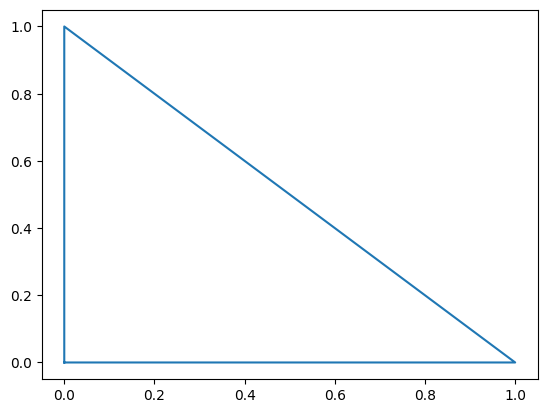

In [174]:
import matplotlib.pyplot as plt
plt.plot([0,0,1,0], [0,1,0,0])

plt.show()